### Importing libs

In [1]:
from utils.data_set import get_data_json, extract_data_set_info
from utils.matrix import fix_diagonal_weight
from model.model import BSS
from model.heuristics import closest_neighbor
from typing import Set, List, Tuple, Dict, Any
import networkx as nx
import mip
import pandas as pd
import matplotlib.pyplot as plt

#### Import data

In [2]:
try:
    data_set = get_data_json("../../data/ReggioEmilia/4ReggioEmilia30.json")

    (num_vertices, demands, vehicle_capacity, distance_matrix) = extract_data_set_info(
        data_set
    )

    fix_diagonal_weight(distance_matrix)

    V = set(range(num_vertices))
    A = {(i, j): distance_matrix[i, j] for i in V for j in V}
    m = 1
    Q = vehicle_capacity
    q = demands
    c = distance_matrix

    problem = BSS(V, A, m, Q, q, c)
except Exception as e:
    raise e

2024-09-03 13:39:02.113 | SUCCESS  | utils.data_set:get_data_json:23 - JSON file loaded correctly


#### Visualizing the distance matrix

In [3]:
df = pd.DataFrame(problem.c)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,3700,4000,3900,4900,3900,4800,3800,4000,2600,4600,3800,3000,3500
1,4300,0,1300,300,2400,1200,1300,2600,1600,1200,1000,600,1400,800
2,4500,900,0,900,2100,900,1000,1900,1300,2100,700,1400,2200,500
3,4500,300,1300,0,2200,1200,1000,2500,1600,1500,700,800,1600,800
4,5500,2200,2600,2000,0,3100,1200,3600,3200,2500,1800,2000,2600,2700
5,3700,800,900,1100,2900,0,1800,1500,500,2000,1500,1300,1700,400
6,5300,1400,1800,1100,2000,2300,0,2700,2300,2200,900,1800,2400,1900
7,3500,2200,1700,2400,3600,1500,2400,0,1400,3000,2400,2600,2700,1800
8,4300,800,1100,1000,3100,1000,2000,1500,0,1600,1700,1200,1300,600
9,3300,1600,2600,1800,2300,2500,2200,3000,2700,0,2100,1200,800,2100


#### Setting a flow variable for all (i, j) $\in$ A

In [4]:
problem.f = {
    (i, j): problem.model.add_var(name=f"f_{i}_{j}", var_type=mip.INTEGER)
    for i in V
    for j in V
}

In [5]:
problem.model += mip.xsum(problem.f[i, i] for i in V) == 0

for j in V - {0}:
    problem.model += (
        mip.xsum(problem.f[j, i] for i in V if i != j)
        - mip.xsum(problem.f[i, j] for i in V if i != j)
        == q[j]
    )

for i in V:
    for j in V:
        if i != j:
            flow_lower_bound = max(0, q[i], -q[j]) * problem.x[i][j]
            flow_upper_bound = min(Q, Q + q[i], Q - q[j]) * problem.x[i][j]

            problem.model += problem.f[i, j] >= flow_lower_bound
            problem.model += problem.f[i, j] <= flow_upper_bound

#### Generate an initial solution

In [6]:
depot = 0
customers = [i for i in V - {0}]

demand = {station: demands for station, demands in enumerate(q)}

solutions = closest_neighbor(depot, customers, demand, c, capacity=vehicle_capacity)
solutions

[[0, 9, 12, 11, 1, 3, 10, 6, 2, 13, 5, 8, 7, 0], [0, 4, 0]]

In [7]:
solution_list = []
for solution in solutions:
    for i in range(0, len(solution) - 1):
        j = i + 1
        solution_list.append((problem.x[solution[i]][solution[j]], 1.0))

#### implement separation prodecure

In [8]:
class SeparationProcedure(mip.ConstrsGenerator):
    def __init__(
        self, V: Set[int], A: Dict[Tuple[int, int], Any], x: List[List[mip.Var]]
    ):
        self.V = V
        self.A = A
        self.x = x

    def generate_constrs(self, model: mip.Model, depth: int = 0, npass: int = 0):
        y, vertices, edges, cut_pool, G, depot = (
            model.translate(self.x),
            self.V,
            self.A,
            mip.CutPool(),
            nx.DiGraph(),
            0,
        )

        for vertice in vertices:
            G.add_node(vertice)

        for source, target in edges:
            if source != target and y[source][target].x > 1e-6:
                G.add_edge(source, target, capacity=y[source][target].x)

        for node in list(G.nodes()):
            if node != depot:
                flow_value, _ = nx.maximum_flow(G, depot, node)

                if flow_value < 1:
                    _, partition = nx.minimum_cut(G, depot, node)
                    S, _ = partition
                    if 0 not in S and len(S) != 0:
                        cut = mip.xsum(y[i][j] for i in S for j in S) <= len(S) - 1
                        cut_pool.add(cut)

        for cut in cut_pool.cuts:
            model += cut

In [9]:
problem.model.start = solution_list
problem.model.cuts_generator = SeparationProcedure(V, A, problem.x)
problem.model.optimize()

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Clp0024I Matrix will be packed to eliminate 53 small elements
Coin0506I Presolve 352 (-57) rows, 364 (-28) columns and 1298 (-147) elements
Clp1000I sum of infeasibilities 0.323258 - average 0.000918347, 103 fixed columns
Coin0506I Presolve 238 (-114) rows, 235 (-129) columns and 923 (-375) elements
Clp0029I End of values pass after 235 iterations
Clp0014I Perturbing problem by 0.001% of 4.8101535 - largest nonzero change 5.5708976e-05 ( 0.00096646154%) - largest zero change 2.982246e-05
Clp0000I Optimal - objective value 18187.381
Clp0000I Optimal - objective value 18187.381
Coin0511I After Postsolve, objective 18187.381, infeasibilities - dual 0 (0), primal 0 (0)
Clp0014I Perturbing problem by 0.001% of 5.1837674 - largest nonzero change 5.3569463e-05 ( 0.00082704334%) - largest zero change 2.982246e-05
Clp0000I Optimal - object

<OptimizationStatus.OPTIMAL: 0>

In [10]:
if problem.model.num_solutions:
    optimal_route = [
        (origin, destination)
        for origin in V
        for destination in V
        if problem.x[origin][destination].x >= 0.5
    ]
    optimal_flow = [
        (origin, destination)
        for origin in V
        for destination in V
        if problem.f[origin, destination].x and problem.x[origin][destination].x >= 0.5
    ]

    for origin, destination in optimal_route:
        variable_name = f"x_{origin}_{destination}"
        variable_value = problem.x[origin][destination].x
        print(f"{problem.model.var_by_name(variable_name)} = {variable_value}")

x_0_3 = 1.0
x_1_11 = 1.0
x_2_10 = 1.0
x_3_1 = 1.0
x_4_6 = 1.0
x_5_8 = 1.0
x_6_3 = 1.0
x_7_5 = 1.0
x_8_13 = 1.0
x_9_7 = 1.0
x_10_4 = 1.0
x_11_12 = 1.0
x_12_0 = 1.0
x_12_9 = 1.0
x_13_2 = 1.0


In [11]:
print("Initial demand at each station:")
for station, demand in enumerate(q):
    print(f"Station {station}: {demand}")


Initial demand at each station:
Station 0: 0
Station 1: -3
Station 2: 1
Station 3: 2
Station 4: -5
Station 5: 2
Station 6: -10
Station 7: -2
Station 8: -2
Station 9: 3
Station 10: -1
Station 11: -6
Station 12: -9
Station 13: 2


In [12]:
print("Optimal flow between stations:")
for origin, destination in optimal_flow:
    flow_var_name = f"f_{origin}_{destination}"
    flow_value = problem.f[origin, destination].x
    print(f"Flow from Station {origin} to Station {destination}: {flow_value}")

Optimal flow between stations:
Flow from Station 0 to Station 3: 28.0
Flow from Station 1 to Station 11: 27.0
Flow from Station 2 to Station 10: 16.0
Flow from Station 3 to Station 1: 30.0
Flow from Station 4 to Station 6: 10.0
Flow from Station 5 to Station 8: 15.0
Flow from Station 7 to Station 5: 13.0
Flow from Station 8 to Station 13: 13.0
Flow from Station 9 to Station 7: 15.0
Flow from Station 10 to Station 4: 15.0
Flow from Station 11 to Station 12: 21.0
Flow from Station 12 to Station 9: 12.0
Flow from Station 13 to Station 2: 15.0


In [13]:
def plot_route(V, route, pos=None):
    G = nx.DiGraph()
    G.add_nodes_from(V)
    G.add_edges_from(route)

    if pos is None:
        pos = nx.spring_layout(G)

    plt.figure(figsize=(12, 8))

    # Draw all nodes except 0 in light blue
    nx.draw_networkx_nodes(
        G, pos, nodelist=set(V) - {0}, node_color="lightblue", node_size=500
    )

    # Draw node 0 in red
    nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color="red", node_size=500)

    nx.draw_networkx_labels(G, pos)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=route, edge_color="grey", arrows=True)

    # Add edge labels (distances)
    edge_labels = {(i, j): f"{problem.c[i,j]}" for i, j in route}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Bike-sharing System Route")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

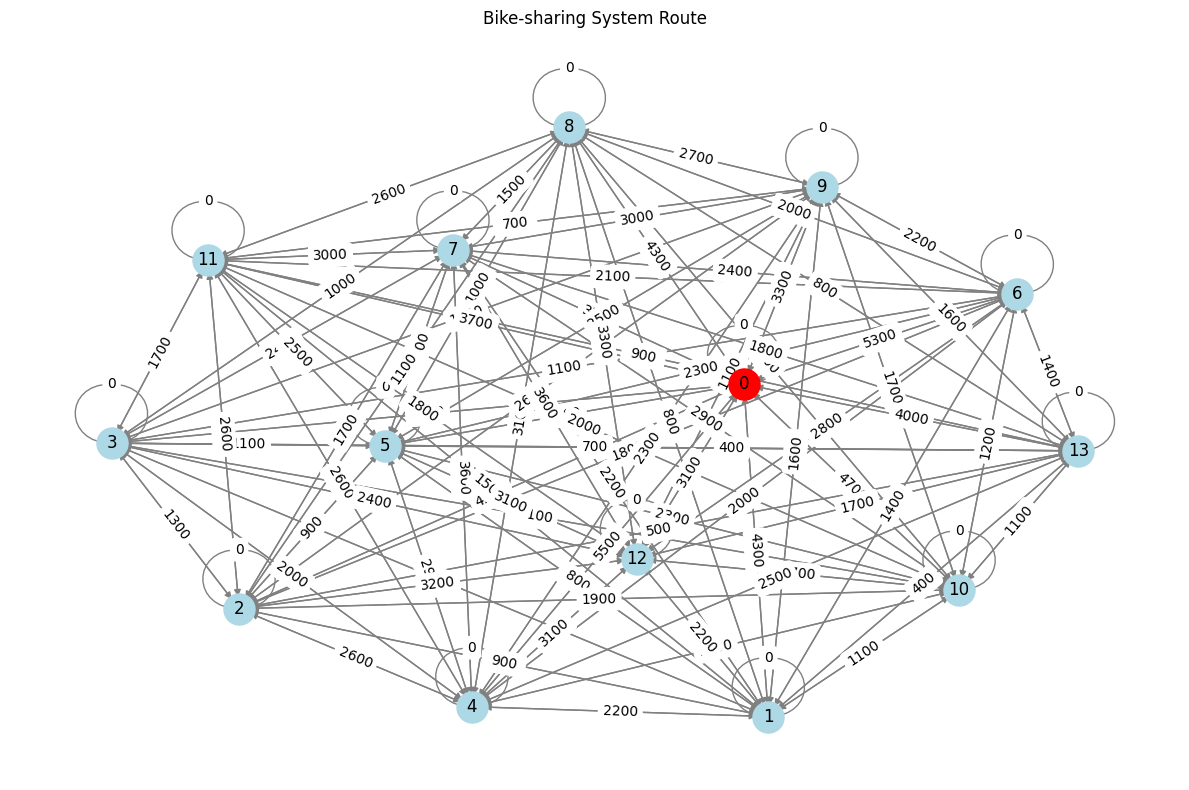

In [14]:
plot_route(V, A)

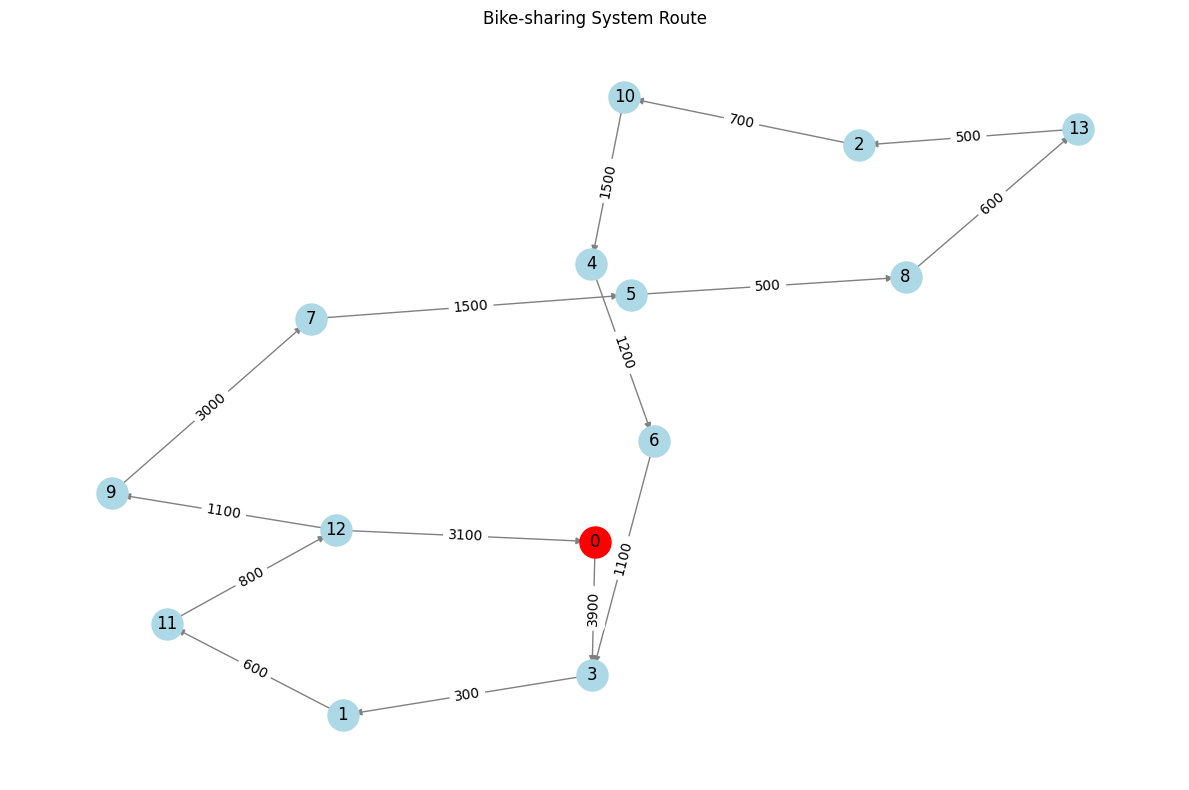

In [15]:
plot_route(V, optimal_route)